## Recommendations with MovieTweetings: Collaborative Filtering

One of the most popular methods for making recommendations is **collaborative filtering**.  In collaborative filtering, you are using the collaboration of user-item recommendations to assist in making new recommendations.  

There are two main methods of performing collaborative filtering:

1. **Neighborhood-Based Collaborative Filtering**, which is based on the idea that we can either correlate items that are similar to provide recommendations or we can correlate users to one another to provide recommendations.

2. **Model Based Collaborative Filtering**, which is based on the idea that we can use machine learning and other mathematical models to understand the relationships that exist amongst items and users to predict ratings and provide ratings.


In this notebook, you will be working on performing **neighborhood-based collaborative filtering**.  There are two main methods for performing collaborative filtering:

1. **User-based collaborative filtering:** In this type of recommendation, users related to the user you would like to make recommendations for are used to create a recommendation.

2. **Item-based collaborative filtering:** In this type of recommendation, first you need to find the items that are most related to each other item (based on similar ratings).  Then you can use the ratings of an individual on those similar items to understand if a user will like the new item.

In this notebook you will be implementing **user-based collaborative filtering**.  However, it is easy to extend this approach to make recommendations using **item-based collaborative filtering**.  First, let's read in our data and necessary libraries.

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tests as t
!pip install progressbar
import progressbar # You may need to go to the terminal and pip install this!
from scipy.sparse import csr_matrix
from IPython.display import HTML


%matplotlib inline

# Read in the datasets
movies = pd.read_csv('movies_clean.csv')
reviews = pd.read_csv('reviews_clean.csv')

del movies['Unnamed: 0']
del reviews['Unnamed: 0']

print(reviews.head())

smart-open 1.6.0 requires bz2file, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


   user_id  movie_id  rating   timestamp                 date  month_1  \
0        1     68646      10  1381620027  2013-10-12 23:20:27        0   
1        1    113277      10  1379466669  2013-09-18 01:11:09        0   
2        2    422720       8  1412178746  2014-10-01 15:52:26        0   
3        2    454876       8  1394818630  2014-03-14 17:37:10        0   
4        2    790636       7  1389963947  2014-01-17 13:05:47        0   

   month_2  month_3  month_4  month_5    ...      month_9  month_10  month_11  \
0        0        0        0        0    ...            0         1         0   
1        0        0        0        0    ...            0         0         0   
2        0        0        0        0    ...            0         1         0   
3        0        0        0        0    ...            0         0         0   
4        0        0        0        0    ...            0         0         0   

   month_12  year_2013  year_2014  year_2015  year_2016  year_2017  

### Measures of Similarity

When using **neighborhood** based collaborative filtering, it is important to understand how to measure the similarity of users or items to one another.  

There are a number of ways in which we might measure the similarity between two vectors (which might be two users or two items).  In this notebook, we will look specifically at two measures used to compare vectors:

* **Pearson's correlation coefficient**

Pearson's correlation coefficient is a measure of the strength and direction of a linear relationship. The value for this coefficient is a value between -1 and 1 where -1 indicates a strong, negative linear relationship and 1 indicates a strong, positive linear relationship. 

If we have two vectors x and y, we can define the correlation between the vectors as:


$$CORR(x, y) = \frac{\text{COV}(x, y)}{\text{STDEV}(x)\text{ }\text{STDEV}(y)}$$

where 

$$\text{STDEV}(x) = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2}$$

and 

$$\text{COV}(x, y) = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})$$

where n is the length of the vector, which must be the same for both x and y and $\bar{x}$ is the mean of the observations in the vector.  

We can use the correlation coefficient to indicate how alike two vectors are to one another, where the closer to 1 the coefficient, the more alike the vectors are to one another.  There are some potential downsides to using this metric as a measure of similarity.  You will see some of these throughout this workbook.


* **Euclidean distance**

Euclidean distance is a measure of the straightline distance from one vector to another.  Because this is a measure of distance, larger values are an indication that two vectors are different from one another (which is different than Pearson's correlation coefficient).

Specifically, the euclidean distance between two vectors x and y is measured as:

$$ \text{EUCL}(x, y) = \sqrt{\sum_{i=1}^{n}(x_i - y_i)^2}$$

**Different from the correlation coefficient, no scaling is performed in the denominator.  Therefore, you need to make sure all of your data are on the same scale when using this metric.**

**Note:** Because measuring similarity is often based on looking at the distance between vectors, it is important in these cases to scale your data or to have all data be in the same scale.  If some measures are on a 5 point scale, while others are on a 100 point scale, you are likely to have non-optimal results due to the difference in variability of your features.  In this case, we will not need to scale data because they are all on a 10 point scale, but it is always something to keep in mind!

------------

### User-Item Matrix

In order to calculate the similarities, it is common to put values in a matrix.  In this matrix, users are identified by each row, and items are represented by columns.  


![alt text](images/userxitem.png "User Item Matrix")


In the above matrix, you can see that **User 1** and **User 2** both used **Item 1**, and **User 2**, **User 3**, and **User 4** all used **Item 2**.  However, there are also a large number of missing values in the matrix for users who haven't used a particular item.  A matrix with many missing values (like the one above) is considered **sparse**.

Our first goal for this notebook is to create the above matrix with the **reviews** dataset.  However, instead of 1 values in each cell, you should have the actual rating.  

The users will indicate the rows, and the movies will exist across the columns. To create the user-item matrix, we only need the first three columns of the **reviews** dataframe, which you can see by running the cell below.

In [2]:
user_items = reviews[['user_id', 'movie_id', 'rating']]
user_items.head()

,user_id,movie_id,rating
0,1,68646,10
1,1,113277,10
2,2,422720,8
3,2,454876,8
4,2,790636,7


In [5]:
# only worked on very small set
pd.pivot_table(user_items.head(10), values=['rating'], index=['user_id'], columns=['movie_id'])

rating                                                          \
movie_id 68646   113277  422720  454876  790636  816711  1091191 1103275   
user_id                                                                    
1           10.0    10.0     NaN     NaN     NaN     NaN     NaN     NaN   
2            NaN     NaN     8.0     8.0     7.0     8.0     7.0     7.0   

                          
movie_id 1322269 1390411  
user_id                   
1            NaN     NaN  
2            7.0     8.0

In [3]:
# this did not work on udacity/ my ubuntu ,   only worked on my windows
user_by_movie = reviews[['user_id', 'movie_id', 'rating']].groupby(by=['user_id','movie_id'])['rating'].max().unstack()

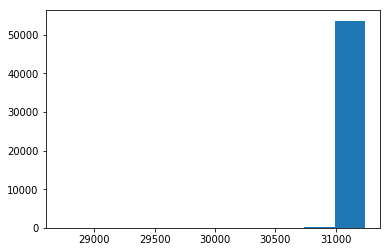

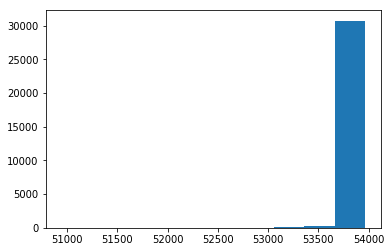

In [5]:
import matplotlib.pyplot as plt
plt.hist(user_by_movie.isnull().sum(axis=1));  # per user
plt.show()  # over 50k users have about 30K movie miss
plt.hist(user_by_movie.isnull().sum(axis=0));  # per movie
plt.show() # over 30k movies have about 50K user miss

In [13]:
user_by_movie.isnull().sum(axis=1).count() # per user  

53968

In [14]:
user_by_movie.isnull().sum(axis=0).count()

31245

In [6]:
user_items.user_id.nunique()   # more users than movie

53968

In [11]:
user_items.movie_id.nunique()

31245

### Creating the User-Item Matrix

In order to create the user-items matrix (like the one above), I personally started by using a [pivot table](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html). 

However, I quickly ran into a memory error (a common theme throughout this notebook).  I will help you navigate around many of the errors I had, and achieve useful collaborative filtering results! 

_____

`1.` Create a matrix where the users are the rows, the movies are the columns, and the ratings exist in each cell, or a NaN exists in cells where a user hasn't rated a particular movie. If you get a memory error (like I did), [this link here](https://stackoverflow.com/questions/39648991/pandas-dataframe-pivot-memory-error) might help you!

In [ ]:
# Create user-by-item matrix  toooooooo time consuming did not work either udacity/my ubuntu or my windows
#user_by_movie = pd.pivot_table(user_items, values=['rating'], index=['user_id'], columns=['movie_id'])

Check your results below to make sure your matrix is ready for the upcoming sections.

In [4]:
assert movies.shape[0] == user_by_movie.shape[1], "Oh no! Your matrix should have {} columns, and yours has {}!".format(movies.shape[0], user_by_movie.shape[1])
assert reviews.user_id.nunique() == user_by_movie.shape[0], "Oh no! Your matrix should have {} rows, and yours has {}!".format(reviews.user_id.nunique(), user_by_movie.shape[0])
print("Looks like you are all set! Proceed!")
#HTML('<img src="images/greatjob.webp">')

Looks like you are all set! Proceed!


`2.` Now that you have a matrix of users by movies, use this matrix to create a dictionary where the key is each user and the value is an array of the movies each user has rated.

In [15]:
user_by_movie.head()

movie_id,8,10,12,25,91,417,439,443,628,833,...,8144778,8144868,8206708,8289196,8324578,8335880,8342748,8342946,8402090,8439854
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
np.array(user_by_movie.loc[1350].dropna().index)

array([ 974015, 1211837, 1396484, 1596363, 1895587, 2250912, 2527336,
       2582782, 2719848, 2911666, 3263904, 3799694, 4129428, 5013056,
       5764096], dtype=int64)

In [28]:
user_by_movie.loc[1350,3263904]

6.0

In [29]:
user_by_movie.shape[1] - user_by_movie.loc[1350].isnull().sum()

15

In [30]:
user_by_movie.index

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,     9,
               10,
            ...
            53959, 53960, 53961, 53962, 53963, 53964, 53965, 53966, 53967,
            53968],
           dtype='int64', name='user_id', length=53968)

In [5]:
# Create a dictionary with users and corresponding movies seen

def movies_watched(user_id):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    OUTPUT:
    movies - an array of movies the user has watched
    '''
    
    movies = np.array(user_by_movie.loc[user_id].dropna().index)
    
    return movies


def create_user_movie_dict():
    '''
    INPUT: None
    OUTPUT: movies_seen - a dictionary where each key is a user_id and the value is an array of movie_ids
    
    Creates the movies_seen dictionary
    '''
    movies_seen = {}
    bar = progressbar.ProgressBar()
    for user in bar(list(user_by_movie.index)):
        movies_seen[user] = movies_watched(user)             

    return movies_seen

movies_seen = create_user_movie_dict()

100% |########################################################################|


In [9]:
len(movies_seen.keys())

53968

In [35]:
len(movies_seen[1350])

15

In [38]:
len(list(movies_seen.keys()))

53968

In [39]:
movies_seen.get(1350)

array([ 974015, 1211837, 1396484, 1596363, 1895587, 2250912, 2527336,
       2582782, 2719848, 2911666, 3263904, 3799694, 4129428, 5013056,
       5764096], dtype=int64)

`3.` If a user hasn't rated more than 2 movies, we consider these users "too new".  Create a new dictionary that only contains users who have rated more than 2 movies.  This dictionary will be used for all the final steps of this workbook.

In [6]:
# Remove individuals who have watched 2 or fewer movies - don't have enough data to make recs

def create_movies_to_analyze(movies_seen, lower_bound=2):
    '''
    INPUT:  
    movies_seen - a dictionary where each key is a user_id and the value is an array of movie_ids
    lower_bound - (an int) a user must have more movies seen than the lower bound to be added to the movies_to_analyze dictionary

    OUTPUT: 
    movies_to_analyze - a dictionary where each key is a user_id and the value is an array of movie_ids
    
    The movies_seen and movies_to_analyze dictionaries should be the same except that the output dictionary has removed 
    
    '''
    movies_to_analyze = {}
    bar = progressbar.ProgressBar()
    for user in bar(list(movies_seen.keys())):
        if(len(movies_seen.get(user))>lower_bound):
            movies_to_analyze[user] = movies_seen.get(user)
    
    return movies_to_analyze


movies_to_analyze = create_movies_to_analyze(movies_seen)

100% |########################################################################|


In [41]:
len(movies_to_analyze.keys())  # half the population dropped with > lower_bound 2

23512

In [11]:
# Run the tests below to check that your movies_to_analyze matches the solution
assert len(movies_to_analyze) == 23512, "Oops!  It doesn't look like your dictionary has the right number of individuals."
assert len(movies_to_analyze[2]) == 23, "Oops!  User 2 didn't match the number of movies we thought they would have."
assert len(movies_to_analyze[7])  == 3, "Oops!  User 7 didn't match the number of movies we thought they would have."
print("If this is all you see, you are good to go!")

If this is all you see, you are good to go!


### Calculating User Similarities

Now that you have set up the **movies_to_analyze** dictionary, it is time to take a closer look at the similarities between users.  Below is the pseudocode for how I thought about determining the similarity between users:

```
for user1 in movies_to_analyze
    for user2 in movies_to_analyze
        see how many movies match between the two users
        if more than two movies in common
            pull the overlapping movies
            compute the distance/similarity metric between ratings on the same movies for the two users
            store the users and the distance metric
```

However, this took a very long time to run, and other methods of performing these operations did not fit on the workspace memory!

Therefore, your task for this question is to look at a few specific examples of the correlation between ratings given by two users.  For this question consider you want to compute the [correlation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.corr.html) between users.

`4.` Using the **movies_to_analyze** dictionary and **user_by_movie** dataframe, create a function that computes the correlation between the ratings of similar movies for two users.  Then use your function to compare your results to ours using the tests below.  

In [106]:
user2 = movies_to_analyze[2]
user2

array([ 422720,  454876,  790636,  816711, 1091191, 1103275, 1322269,
       1390411, 1398426, 1431045, 1433811, 1454468, 1535109, 1675434,
       1798709, 2017038, 2024544, 2294629, 2361509, 2381249, 2726560,
       2883512, 3079380], dtype=int64)

In [105]:
user104 = movies_to_analyze[104]
user104

array([ 356150,  359950,  364725,  454876,  463985,  770828,  800369,
        816711,  831387,  903624,  942385, 1049413, 1210819, 1213663,
       1234721, 1245492, 1300854, 1335975, 1343092, 1351685, 1408101,
       1418377, 1428538, 1453405, 1454468, 1457767, 1499658, 1535108,
       1535109, 1538403, 1549920, 1583421, 1591095, 1596343, 1623205,
       1650554, 1663662, 1690953, 1706620, 1717715, 1840309, 1843866,
       1854564, 1893256, 1899353, 1905041, 1924429, 1939659, 1951264,
       1981115, 2024469, 2103281, 2234155, 2294449], dtype=int64)

In [61]:
user66 = movies_to_analyze[66]
#user66

In [63]:
user_intersect = np.intersect1d(user2,user66)
user_intersect

array([1454468, 1798709, 2883512], dtype=int64)

In [64]:
user_by_movie.head()

movie_id,8,10,12,25,91,417,439,443,628,833,...,8144778,8144868,8206708,8289196,8324578,8335880,8342748,8342946,8402090,8439854
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
user_by_movie.loc[[2,66],user_intersect]

movie_id,1454468,1798709,2883512
user_id,,,
2,8.0,10.0,8.0
66,6.0,9.0,8.0


In [66]:
df = user_by_movie.loc[[2,66],user_intersect].T
df

user_id,2,66
movie_id,,
1454468,8.0,6.0
1798709,10.0,9.0
2883512,8.0,8.0


In [69]:
df.corr(method='pearson')

user_id,2,66
user_id,,
2,1.000000,0.755929
66,0.755929,1.000000


In [71]:
df.corr(method='spearman')

user_id,2,66
user_id,,
2,1.000000,0.866025
66,0.866025,1.000000


In [75]:
df.corr(method='kendall') #.loc[2,66]

user_id,2,66
user_id,,
2,1.000000,0.816497
66,0.816497,1.000000


In [105]:
def compute_correlation(user1, user2, method_corr ='spearman'):
    '''
    INPUT
    user1 - int user_id
    user2 - int user_id
    OUTPUT
    the correlation between the matching ratings between the two users
    '''
    user1_movie = movies_to_analyze[user1]
    user2_movie = movies_to_analyze[user2]
    user_intersect = np.intersect1d(user1_movie,user2_movie)
    print(user_intersect)
    df = user_by_movie.loc[[user1, user2],user_intersect].T
    print(df)
    df_corr = df.corr(method = 'spearman')
    print(df_corr)
    #print(df_corr)
    
    corr =  df_corr.iloc[0, 1]
  
    return corr #return the correlation

In [119]:
from scipy.stats import spearmanr, kendalltau
x = pd.Series(np.array([8, 8, 8, 8]))
y = pd.Series(np.array([9, 7, 7, 9]))
#spearmanr(x, y)
print(x.rank())
print(y.rank())
kendalltau(x, y)

0    2.5
1    2.5
2    2.5
3    2.5
dtype: float64
0    3.5
1    1.5
2    1.5
3    3.5
dtype: float64


KendalltauResult(correlation=nan, pvalue=nan)

In [114]:
compute_correlation(2, 104)

[ 454876  816711 1454468 1535109]
user_id   2    104
movie_id          
454876    8.0  9.0
816711    8.0  7.0
1454468   8.0  7.0
1535109   8.0  9.0
user_id  2    104
user_id          
2        NaN  NaN
104      NaN  1.0


nan

In [106]:
# Read in solution correlations - this will take some time to read in
import pickle   #"data/Term2/recommendations/lesson1/data/corrs.p"
corrs_import = pd.read_pickle("data/corrs.p")
df_corrs = pd.DataFrame(corrs_import) 
df_corrs.columns = ['user1', 'user2', 'movie_corr']

In [84]:
df_corrs.head()

,user1,user2,movie_corr
0,2,2,1.000000
1,2,66,0.755929
2,2,90,-0.314270
3,2,99,0.484200
4,2,104,NaN


In [85]:
df_corrs.query("user1 == 2 and user2 == 2")['movie_corr'][0]

1.0

In [100]:
compute_correlation(2,2)

1.0

In [102]:
np.isnan(compute_correlation(2,104))

True

In [101]:
# Test your function against the solution
assert compute_correlation(2,2) == df_corrs.query("user1 == 2 and user2 == 2")['movie_corr'][0], "Oops!  The correlation between a user and itself should be 1.0."
assert round(compute_correlation(2,66), 2) == round(df_corrs.query("user1 == 2 and user2 == 66")['movie_corr'][1], 2), "Oops!  The correlation between user 2 and 66 should be about 0.76."
assert np.isnan(compute_correlation(2,104)) == np.isnan(df_corrs.query("user1 == 2 and user2 == 104")['movie_corr'][4]), "Oops!  The correlation between user 2 and 104 should be a NaN."

print("If this is all you see, then it looks like your function passed all of our tests!")

If this is all you see, then it looks like your function passed all of our tests!


In [110]:
df_corrs.movie_corr.isnull().sum()

2526710

### Why the NaN's?

If the function you wrote passed all of the tests, then you have correctly set up your function to calculate the correlation between any two users.  The **df_corrs** dataframe created in the cell leading up to the tests holds combinations of users along with their corresponding correlation.  

`5.` But one question is, why are we still obtaining **NaN** values?  Look at the header below for users 2 and 104 - they have a correlation of **NaN** - why?

In [103]:
df_corrs.head()

,user1,user2,movie_corr
0,2,2,1.000000
1,2,66,0.755929
2,2,90,-0.314270
3,2,99,0.484200
4,2,104,NaN


##### variable for user1 exhibits no variation in its values, for spearman (rank)/pearson (raw) demoninator is zero. Even for kendall's tau assumption to use sign equation is values be all unique, which is not here. therefore infinity values NaN

Leave your thoughts here about why the NaN exists, and use the cells below to validate your thoughts.  These Nan's ultimately make the correlation coefficient a less than optimal measure of similarity between two users.

In [120]:
# Which movies did both user 2 and user 104 see?
compute_correlation(2, 104)

[ 454876  816711 1454468 1535109]
user_id   2    104
movie_id          
454876    8.0  9.0
816711    8.0  7.0
1454468   8.0  7.0
1535109   8.0  9.0
user_id  2    104
user_id          
2        NaN  NaN
104      NaN  1.0


nan

`6.` Because the correlation coefficient proved to be less than optimal for relating user ratings to one another, we could instead calculate the euclidean distance between the ratings.  I found [this post](https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy) particularly helpful when I was setting up my function.  This function should be very similar to your previous function.  When you feel confident with your function, test it against our results.

In [7]:
def compute_euclidean_dist(user1, user2):
    '''
    INPUT
    user1 - int user_id
    user2 - int user_id
    OUTPUT
    the euclidean distance between user1 and user2
    '''
    user1_movie = movies_to_analyze[user1]
    user2_movie = movies_to_analyze[user2]
    user_intersect = np.intersect1d(user1_movie,user2_movie)
    #print(user_intersect)
    df = user_by_movie.loc[[user1, user2],user_intersect].T
    #print(df)
    dist = np.linalg.norm(df[user1] - df[user2])
    #print(dist)
  
    return dist #return the euclidean distance

In [8]:
compute_euclidean_dist(2, 104)

2.0

In [9]:
# Read in solution euclidean distances
#data/Term2/recommendations/lesson1/data/dists.p
df_dists = pd.read_pickle("data/dists.p")

In [10]:
# Test your function against the solution
assert compute_euclidean_dist(2,2) == df_dists.query("user1 == 2 and user2 == 2")['eucl_dist'][0], "Oops!  The distance between a user and itself should be 0.0."
assert round(compute_euclidean_dist(2,66), 2) == round(df_dists.query("user1 == 2 and user2 == 66")['eucl_dist'][1], 2), "Oops!  The distance between user 2 and 66 should be about 2.24."
assert np.isnan(compute_euclidean_dist(2,104)) == np.isnan(df_dists.query("user1 == 2 and user2 == 104")['eucl_dist'][4]), "Oops!  The distance between user 2 and 104 should be 2."

print("If this is all you see, then it looks like your function passed all of our tests!")

If this is all you see, then it looks like your function passed all of our tests!


In [129]:
df_dists.head()

,user1,user2,eucl_dist
0,2,2,0.000000
1,2,66,2.236068
2,2,90,5.385165
3,2,99,2.828427
4,2,104,2.000000


In [130]:
df_dists.eucl_dist.max()

62.03224967708329

In [131]:
df_dists.shape

(31813482, 3)

### Using the Nearest Neighbors to Make Recommendations

In the previous questions, you read in **df_corrs** and **df_dists**. Therefore, you have a measure of distance and similarity for each user to every other user. These dataframes hold every possible combination of users, as well as the corresponding correlation or euclidean distance, respectively.

Because of the **NaN** values that exist within **df_corrs**, we will proceed using **df_dists**. You will want to find the users that are 'nearest' each user.  Then you will want to find the movies the closest neighbors have liked to recommend to each user.

I made use of the following objects:

* df_dists (to obtain the neighbors)
* user_items (to obtain the movies the neighbors and users have rated)
* movies (to obtain the names of the movies)

`7.` Complete the functions below, which allow you to find the recommendations for any user.  There are five functions which you will need:

* **find_closest_neighbors** - this returns a list of user_ids from closest neighbor to farthest neighbor using euclidean distance


* **movies_liked** - returns an array of movie_ids


* **movie_names** - takes the output of movies_liked and returns a list of movie names associated with the movie_ids


* **make_recommendations** - takes a user id and goes through closest neighbors to return a list of movie names as recommendations


* **all_recommendations** = loops through every user and returns a dictionary of with the key as a user_id and the value as a list of movie recommendations

In [132]:
df_dists.head()

,user1,user2,eucl_dist
0,2,2,0.000000
1,2,66,2.236068
2,2,90,5.385165
3,2,99,2.828427
4,2,104,2.000000


In [76]:
df_dists.user1.nunique()

23512

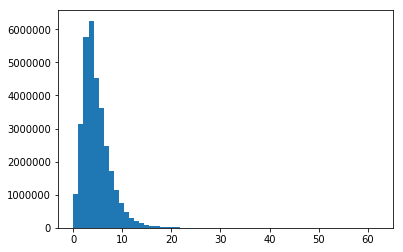

In [21]:
plt.hist(df_dists.eucl_dist,bins=60); # majority between 0-10 euc distance

In [26]:
df_dists.groupby(by=['user1']).count().head(10)

,user2,eucl_dist
user1,,
2,2809,2809
3,23,23
7,23,23
8,4,4
9,77,77
17,97,97
22,2986,2986
24,1009,1009
25,371,371


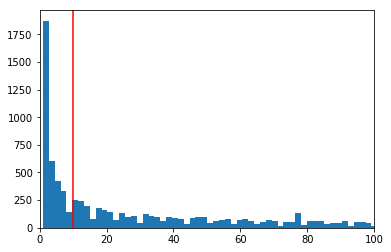

In [40]:
plt.hist(df_dists.groupby(by=['user1']).count()['eucl_dist'],bins=10000); # majority have 
plt.xlim([0,100])
plt.axvline(10,color='red')

In [42]:
df_dists[df_dists['user1']==8].sort_values(by=['eucl_dist'])

,user1,user2,eucl_dist
2855,8,8,0.000000
2856,8,14029,5.385165
2858,8,39788,5.830952
2857,8,15981,7.681146


In [ ]:
df_dists[df_dists['user1']==2].sort_values(by=['eucl_dist']).head(25)

In [18]:
#df_dists[df_dists['user1']==14408].sort_values(by=['eucl_dist'])

In [143]:
movies.head(2)

,movie_id,movie,genre,date,1800's,1900's,2000's,History,News,Horror,...,Fantasy,Romance,Game-Show,Action,Documentary,Animation,Comedy,Short,Western,Thriller
0,8,Edison Kinetoscopic Record of a Sneeze (1894),Documentary|Short,1894,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,10,La sortie des usines Lumière (1895),Documentary|Short,1895,1,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


In [155]:
list(movies[movies.movie_id.isin([5,10,20,8,32,68646])].movie.values)

['Edison Kinetoscopic Record of a Sneeze (1894)',
 'La sortie des usines Lumière (1895)',
 'The Godfather (1972)']

In [157]:
reviews.head(3)

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,1,68646,10,1381620027,2013-10-12 23:20:27,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,1,113277,10,1379466669,2013-09-18 01:11:09,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,422720,8,1412178746,2014-10-01 15:52:26,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0


In [170]:
np.nan>7

False

In [187]:
reviews[(reviews.movie_id==68646) & (reviews.user_id==1)].rating.values[0]

10

In [18]:
#user_items
user_items[(user_items.movie_id==68646) & (user_items.user_id==1)].rating.values[0]

10

In [213]:
x = reviews[reviews.user_id == 2] 
movies_liked = x[x['rating'] >= 7].movie_id.values
movies_liked

array([ 422720,  454876,  790636,  816711, 1091191, 1103275, 1322269,
       1390411, 1398426, 1431045, 1433811, 1454468, 1535109, 1675434,
       1798709, 2017038, 2024544, 2294629, 2361509, 2726560, 2883512,
       3079380], dtype=int64)

In [19]:
x = user_items[user_items.user_id == 2] 
movies_liked = x[x['rating'] >= 7].movie_id.values
movies_liked

array([ 422720,  454876,  790636,  816711, 1091191, 1103275, 1322269,
       1390411, 1398426, 1431045, 1433811, 1454468, 1535109, 1675434,
       1798709, 2017038, 2024544, 2294629, 2361509, 2726560, 2883512,
       3079380], dtype=int64)

In [188]:
list(movies[movies.movie_id.isin([])].movie.values)

[]

In [193]:
reviews.head(5)

,user_id,movie_id,rating,timestamp,date,month_1,month_2,month_3,month_4,month_5,...,month_9,month_10,month_11,month_12,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018
0,1,68646,10,1381620027,2013-10-12 23:20:27,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,1,113277,10,1379466669,2013-09-18 01:11:09,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,2,422720,8,1412178746,2014-10-01 15:52:26,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,2,454876,8,1394818630,2014-03-14 17:37:10,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2,790636,7,1389963947,2014-01-17 13:05:47,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [194]:
reviews[(reviews.movie_id==790636) & (reviews.user_id==2)].rating.values[0]

7

In [221]:
movies_liked(2, min_rating=7)

[ 422720  454876  790636  816711 1091191 1103275 1322269 1390411 1398426
 1431045 1433811 1454468 1535109 1675434 1798709 2017038 2024544 2294629
 2361509 2726560 2883512 3079380]


array([ 422720,  454876,  790636,  816711, 1091191, 1103275, 1322269,
       1390411, 1398426, 1431045, 1433811, 1454468, 1535109, 1675434,
       1798709, 2017038, 2024544, 2294629, 2361509, 2726560, 2883512,
       3079380], dtype=int64)

In [226]:
# for i in find_closest_neighbors(2):
#     print(i)

In [46]:
len(df_dists[df_dists['user1']==14408].sort_values(by=['eucl_dist']).head(10)['user2'].values)

10

In [88]:
df_dists.user1.unique()

array([    2,     3,     7, ..., 53961, 53964, 53966], dtype=int64)

### keep 10 nearset neighbors for timing issue (may be due to second loop)

In [89]:
def find_closest_neighbors(user):
    '''
    INPUT:
        user - (int) the user_id of the individual you want to find the closest users
    OUTPUT:
        closest_neighbors - an array of the id's of the users sorted from closest to farthest away
    '''
    # this list closest to furthest no top cases, 10 top neighbor
    closest_neighbors = df_dists[df_dists['user1']==user].sort_values(by=['eucl_dist']).head(10)['user2'].values
    
    # I treated ties as arbitrary and just kept whichever was easiest to keep using the head method
    # You might choose to do something less hand wavy - order the neighbors
    
    return closest_neighbors
    
    
def movie_names(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids
    
    '''
    movie_lst = list(movies[movies.movie_id.isin(movie_ids)].movie.values)

    return movie_lst

def movie_genre(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids
    
    '''
    movie_genre = list(movies[movies.movie_id.isin(movie_ids)].genre.values)

    return movie_genre


def movies_liked(user_id, min_rating=7):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    min_rating - the minimum rating considered while still a movie is still a "like" and not a "dislike"
    OUTPUT:
    movies_liked - an array of movies the user has watched and liked
    '''
    # the reviews are already sorted by rating/date descendings, this tend to go for newely reviewed movies, pushing recent releases
    x = user_items[user_items['user_id'] == user_id] 
    movies_liked_ = x[x['rating'] >= min_rating].movie_id.values
    #print(movies_liked_)
    return movies_liked_
    
    
def make_recommendations(user, num_recs=10):
    '''
    INPUT:
        user - (int) a user_id of the individual you want to make recommendations for
        num_recs - (int) number of movies to return
    OUTPUT:
        recommendations - a list of movies - if there are "num_recs" recommendations return this many
                          otherwise return the total number of recommendations available for the "user"
                          which may just be an empty list
    '''
    # list closer user to 'user'
    movie_rec = []
    #find_closest_neighbors(user)
    #bar = progressbar.ProgressBar()
    #print(find_closest_neighbors(user))
    for user_ in find_closest_neighbors(user):
        #print(user_,user)
        if(user != user_):
            # list of movies of user_
            #print(movies_liked(user_, min_rating=7))
            for movie_ in movies_liked(user_, min_rating=7):  # maybe sort by highest reviews then suggest

                # get the rating for target main user if exist or not
                # have to do except since if user has no review then is nan
                try:
                    rating_ = user_items[(user_items['movie_id']==movie_) & (user_items['user_id']==user)]['rating'].values[0]
                except:
                    rating_ = np.nan
                #print(user_,movie_,rating_)
                #print(np.isnan(rating_))
                if((np.isnan(rating_)) and (len(movie_rec)<num_recs)):
                    movie_rec.append(movie_)
                    movie_rec = list(set(movie_rec))  #make sure no duplicate from new user2 added
                if(len(movie_rec)==num_recs):
                    recommendations = movie_names(movie_rec) 
                    #print(movie_genre(movie_rec))
                    return recommendations                   
                    
    recommendations = movie_names(movie_rec)   
    #print(movie_genre(movie_rec))
        
    return recommendations

def all_recommendations(num_recs=10):
    '''
    INPUT 
        num_recs (int) the (max) number of recommendations for each user
    OUTPUT
        all_recs - a dictionary where each key is a user_id and the value is an array of recommended movie titles
    '''
    

    # Apply make recs for each user - 
    # hint this may take some time, so you might want to set up a progress bar to watch things progress
    all_recs = {}
    bar = progressbar.ProgressBar()
    for userx in bar(df_dists.user1.unique()):
        all_recs[userx] = make_recommendations(userx)        
    
    return all_recs

all_recs = all_recommendations(10)

100% |########################################################################|


In [82]:
make_recommendations(2, num_recs=10)

['Drama', 'Crime|Drama|Thriller', 'Comedy|Drama', 'Drama|Mystery|Thriller', 'Crime|Drama|Romance', 'Drama|History', 'Action|Crime|Drama', 'Comedy|Drama|Romance', 'Comedy|Drama|Romance', 'Crime|Drama']


['Philadelphia (1993)',
 'Training Day (2001)',
 'About Schmidt (2002)',
 'Insomnia (2002)',
 'The United States of Leland (2003)',
 'Shattered Glass (2003)',
 'Man on Fire (2004)',
 'Flipped (2010)',
 'Silver Linings Playbook (2012)',
 'Lawless (2012)']

In [61]:
reviews[(reviews.movie_id==47034) & (reviews.user_id==29843)].rating.values[0]

7

In [62]:
movies_liked(29843, min_rating=7)

array([  47034,   66921,   83944,   85482,  903657,  993846, 1392190,
       1587310, 2103281, 2395427], dtype=int64)

In [63]:
try:
    reviews[(reviews['movie_id']==47034) & (reviews['user_id']==14408)]['rating'].values[0]
except:
    print('except')

except


In [90]:
#make_recommendations(1503, num_recs=10)

In [91]:
# This loads our solution dictionary so you can compare results
#data/Term2/recommendations/lesson1/data/all_recs.p
all_recs_sol = pd.read_pickle("data/all_recs.p")

In [93]:
assert all_recs[2] == make_recommendations(2), "Oops!  Your recommendations for user 2 didn't match ours."
assert all_recs[26] == make_recommendations(26), "Oops!  It actually wasn't possible to make any recommendations for user 26."
assert all_recs[1503] == make_recommendations(1503), "Oops! Looks like your solution for user 1503 didn't match ours."
print("If you made it here, you now have recommendations for many users using collaborative filtering!")
#HTML('<img src="images/greatjob.webp">')

If you made it here, you now have recommendations for many users using collaborative filtering!


In [150]:
all_recs[66]

['Léon (1994)',
 'Pulp Fiction (1994)',
 'Road to Perdition (2002)',
 'Inglourious Basterds (2009)',
 'The Terminal (2004)',
 'The Imitation Game (2014)',
 'Nightcrawler (2014)',
 'The Theory of Everything (2014)',
 'Murder on the Orient Express (2017)',
 'Under sandet (2015)']

In [151]:
all_recs_sol[66]

['Léon (1994)',
 'Road to Perdition (2002)',
 'The Terminal (2004)',
 'Der Untergang (2004)',
 'Prisoners (2013)',
 'Coco (2017)',
 'Nightcrawler (2014)',
 'Relatos salvajes (2014)',
 'Murder on the Orient Express (2017)',
 'Under sandet (2015)',
 'The Nile Hilton Incident (2017)']

In [152]:
np.intersect1d(all_recs[66],all_recs_sol[66])

array(['Léon (1994)', 'Murder on the Orient Express (2017)',
       'Nightcrawler (2014)', 'Road to Perdition (2002)',
       'The Terminal (2004)', 'Under sandet (2015)'], dtype='<U35')

In [145]:
all_recs[14408]

['A Clockwork Orange (1971)',
 'First Blood (1982)',
 'El Norte (1983)',
 'Love &amp; Mercy (2014)',
 'Argo (2012)',
 'Gravity (2013)',
 "Ender's Game (2013)",
 'The Monuments Men (2014)',
 'About Time (2013)',
 'Transcendence (2014)']

### Now What?

If you made it this far, you have successfully implemented a solution to making recommendations using collaborative filtering. 

`8.` Let's do a quick recap of the steps taken to obtain recommendations using collaborative filtering.  

In [ ]:
# Check your understanding of the results by correctly filling in the dictionary below
a = "pearson's correlation and spearman's correlation"
b = 'item based collaborative filtering'
c = "there were too many ratings to get a stable metric"
d = 'user based collaborative filtering'
e = "euclidean distance and pearson's correlation coefficient"
f = "manhatten distance and euclidean distance"
g = "spearman's correlation and euclidean distance"
h = "the spread in some ratings was zero"
i = 'content based recommendation'

sol_dict = {
    'The type of recommendation system implemented here was a ...': d,
    'The two methods used to estimate user similarity were: ': e,
    'There was an issue with using the correlation coefficient.  What was it?': h
}

t.test_recs(sol_dict)  # solution is correct but for some reason get error

Additionally, let's take a closer look at some of the results.  There are three objects that you read in to check your results against the solution:

* **df_corrs** - a dataframe of user1, user2, pearson correlation between the two users
* **df_dists** - a dataframe of user1, user2, euclidean distance between the two users
* **all_recs_sol** - a dictionary of all recommendations (key = user, value = list of recommendations)

Looping your results from the correlation and euclidean distance functions through every pair of users could have been used to create the first two objects (I don't recommend doing this given how long it will take).  

`9.`Use these three objects along with the cells below to correctly fill in the dictionary below and complete this notebook!

In [122]:
a = 567
b = 1503
c = 1319
d = 1325
e = 2526710
f = 0
g = 'Use another method to make recommendations - content based, knowledge based, or model based collaborative filtering'

sol_dict2 = {
    'For how many pairs of users were we not able to obtain a measure of similarity using correlation?': e,
    'For how many pairs of users were we not able to obtain a measure of similarity using euclidean distance?': f,
    'For how many users were we unable to make any recommendations for using collaborative filtering?': c,
    'For how many users were we unable to make 10 recommendations for using collaborative filtering?': d,
    'What might be a way for us to get 10 recommendations for every user?': g   
}

t.test_recs2(sol_dict2)

"That's right! All of your solutions look good!"

In [121]:
count = 0
for key in list(all_recs.keys()):
    if(len(all_recs[key])==0):
        count += 1
print(count)

1370


In [ ]:
# Users without recs
#1370/ 1485 /

In [ ]:
# NaN correlation values


In [127]:
x = [1, 2, 3]
x.extend([4, 5])
print (x)

[1, 2, 3, 4, 5]


In [131]:
# NaN euclidean distance values
x =[1]
y =[1,2,3.5]
x.extend(y)
print(x)
list(set(x))

[1, 1, 2, 3.5]


[1, 2, 3.5]

### Another way, keep all the neighbors, drop the 2nd loop
#### in terms of timing dropping second loop but including all neighbors, got to similar timing as above (2nd loop +10 neighbor)

In [132]:
def find_closest_neighbors(user):
    '''
    INPUT:
        user - (int) the user_id of the individual you want to find the closest users
    OUTPUT:
        closest_neighbors - an array of the id's of the users sorted from closest to farthest away
    '''
    # this list closest to furthest no top cases, 10 top neighbor
    closest_neighbors = df_dists[df_dists['user1']==user].sort_values(by=['eucl_dist'])['user2'].values
    
    # I treated ties as arbitrary and just kept whichever was easiest to keep using the head method
    # You might choose to do something less hand wavy - order the neighbors
    
    return closest_neighbors
    
    
def movie_names(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids
    
    '''
    movie_lst = list(movies[movies.movie_id.isin(movie_ids)].movie.values)

    return movie_lst

def movie_genre(movie_ids):
    '''
    INPUT
    movie_ids - a list of movie_ids
    OUTPUT
    movies - a list of movie names associated with the movie_ids
    
    '''
    movie_genre = list(movies[movies.movie_id.isin(movie_ids)].genre.values)

    return movie_genre


def movies_liked(user_id, min_rating=7):
    '''
    INPUT:
    user_id - the user_id of an individual as int
    min_rating - the minimum rating considered while still a movie is still a "like" and not a "dislike"
    OUTPUT:
    movies_liked - an array of movies the user has watched and liked
    '''
    # the reviews are already sorted by rating/date descendings, this tend to go for newely reviewed movies, pushing recent releases
    x = user_items[user_items['user_id'] == user_id] 
    movies_liked_ = x[x['rating'] >= min_rating].movie_id.values
    #print(movies_liked_)
    return movies_liked_
    
    
def make_recommendations(user, num_recs=10):
    '''
    INPUT:
        user - (int) a user_id of the individual you want to make recommendations for
        num_recs - (int) number of movies to return
    OUTPUT:
        recommendations - a list of movies - if there are "num_recs" recommendations return this many
                          otherwise return the total number of recommendations available for the "user"
                          which may just be an empty list
    '''
    # list closer user to 'user'
    movie_rec = []
    for user_ in find_closest_neighbors(user):

        if(user != user_):
            movie_user2_list = movies_liked(user_, min_rating=7)
            movie_user1_list = movies_watched(user)
            #Find the set difference of two arrays.(ar1,ar2)
            #Return the sorted, unique values in ar1 that are not in ar2
            
            movie_rec_tmp = np.setdiff1d(movie_user2_list, movie_user1_list)
            movie_rec.extend(movie_rec_tmp)
            movie_rec = list(set(movie_rec))
            if(len(movie_rec)>=num_recs):
                recommendations = movie_names(movie_rec[0:num_recs])
                return recommendations
                                
                    
    recommendations = movie_names(movie_rec)   
    #print(movie_genre(movie_rec))
        
    return recommendations

def all_recommendations(num_recs=10):
    '''
    INPUT 
        num_recs (int) the (max) number of recommendations for each user
    OUTPUT
        all_recs - a dictionary where each key is a user_id and the value is an array of recommended movie titles
    '''
    

    # Apply make recs for each user - 
    # hint this may take some time, so you might want to set up a progress bar to watch things progress
    all_recs = {}
    bar = progressbar.ProgressBar()
    for userx in bar(df_dists.user1.unique()):
        all_recs[userx] = make_recommendations(userx, num_recs)        
    
    return all_recs

all_recs = all_recommendations(10)

100% |########################################################################|


In [134]:
count = 0
for key in list(all_recs.keys()):
    if(len(all_recs[key])!=10):
        count += 1
print(count)

1302


In [ ]:
#1294/1302 new with all user2 neighbors

In [135]:
count = 0
for key in list(all_recs.keys()):
    if(len(all_recs[key])<10 and len(all_recs[key])>0):
        count += 1
print(count)

8
